# Query SnowEx database for the data we want
* Seth Vanderwilt
* coldfusion GPR-LiDAR
* 7/12/22

## Imports (from https://snowex.hackweek.io/tutorials/core-datasets/03_database_preview.html)

In [1]:
# standard imports
import numpy as np
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt 
import datetime

# some mapping widgets
import ipyleaflet
from ipyleaflet import Map, GeoData, Rectangle, basemaps, LayersControl, basemap_to_tiles, TileLayer, SplitMapControl, Polygon, MagnifyingGlass
import ipywidgets

# database imports
from snowexsql.db import get_db
from snowexsql.data import PointData, LayerData, ImageData, SiteData
from snowexsql.conversions import query_to_geopandas, query_to_pandas, raster_to_rasterio
from snowexsql.db import get_table_attributes

from sqlalchemy.sql import func
from geoalchemy2.types import Raster

import ipyleaflet
from ipyleaflet import Map, Rectangle, basemaps, basemap_to_tiles, TileLayer, SplitMapControl, Polygon
from ipyleaflet import GeoData, LayersControl

import numpy as np
import pandas as pd

from rasterio.plot import show
import shapely.geometry

from geoalchemy2.shape import from_shape
import geoalchemy2.functions as gfunc
import rioxarray
import rasterio


In [2]:
# load the database
db_name = 'snow:hackweek@db.snowexdata.org/snowex'
engine, session = get_db(db_name)

print('SnowEx Database successfully loaded!')

SnowEx Database successfully loaded!


## Queries to see which kinds of data we have available

In [3]:
# from https://snowex.hackweek.io/tutorials/database/2_database_structure.html



# Use the function to see what columns are available to use. 
db_columns = get_table_attributes(PointData)

# Print out the results nicely
print("These are the available columns in the table:\n \n* {}\n".format('\n* '.join(db_columns)))


These are the available columns in the table:
 
* date
* date_accessed
* doi
* easting
* elevation
* equipment
* geom
* instrument
* latitude
* longitude
* metadata
* northing
* observers
* registry
* site_id
* site_name
* time
* time_created
* time_updated
* type
* units
* utm_zone
* value
* version_number



## (Unused) Was curious whether DOI for a dataset was a good way to get the BSU GPR dataset from SnowEx 2020 that we wanted
SnowEx20 Grand Mesa IOP BSU 1 GHz Multi-polarization GPR, Version 1
https://nsidc.org/data/SNEX20_BSU_GPR/versions/1

In [4]:
# session.query(PointData.site_id).distinct().all() # None
# session.query(PointData.registry).distinct().all() # registry fails for some reason?
session.query(PointData.doi).distinct().all()

[('https://doi.org/10.5067/WE9GI1GVMQF6',),
 (None,),
 ('https://doi.org/10.5067/Q2LFK0QSVGS2',),
 ('https://doi.org/10.5067/S5EGFLCIAB18',),
 ('https://doi.org/10.5067/9IA978JIACAR',)]

In [5]:
query = session.query(PointData.type)
query = query.filter(PointData.doi == "https://doi.org/10.5067/Q2LFK0QSVGS2")
types = query.distinct().all()
types

[('swe',), ('depth',), ('two_way_travel',)]

In [6]:
point_site_names = session.query(PointData.site_name).distinct().all()
point_site_names # [(None,), ('Grand Mesa',)]

[(None,), ('Grand Mesa',)]

In [7]:
point_observers = session.query(PointData.observers).distinct().all() # Tate Meehan
point_observers

[('Catherine Breen, Cassie Lumbrazo',),
 (None,),
 ('Ryan Webb',),
 ('Randall Bonnell',),
 ('Tate Meehan',)]

### GPR is point data, so let's query the database to see which point data corresponds to Grand Mesa GPR

In [8]:
# Grab all Point data instruments from our date
point_instruments = session.query(PointData.instrument).distinct().all()
point_type = session.query(PointData.type).distinct().all()


# Clean up point data (i.e. remove tuple)
point_instruments_list = [p[0] for p in point_instruments if p[0] is not None]
point_instruments = ", ".join(point_instruments_list)
point_type_list = [p[0] for p in point_type]
point_type = ", ".join(point_type_list)
print('Point data are: %s, with the following list of parameters: %s' %(point_instruments, point_type))


Point data are: Mala 1600 MHz GPR, Mala 800 MHz GPR, pulse EKKO Pro multi-polarization 1 GHz GPR, pit ruler, mesa, magnaprobe, camera, with the following list of parameters: swe, depth, two_way_travel


Looking at https://nsidc.org/data/snowex/data_summaries we see that in 2020 there are some GPR datasets:
* BSU Grand Mesa **what we want to start, appears to be "pulse EKKO Pro multi-polarization 1 GHz GPR"**
    - https://nsidc.org/data/SNEX20_BSU_GPR/versions/1
* CSU Cameron Pass
* NMU Jemez

For this week we just focused on the Boise State GPR data from 2020-01-29 to 2020-02-09

In [9]:
bsu_gpr_instrument_name = "pulse EKKO Pro multi-polarization 1 GHz GPR"

In [10]:
query = session.query(PointData.observers)
# fixed bug: have to do `query = query.filter(...)` to modify the query
query = query.filter(PointData.instrument == bsu_gpr_instrument_name)

bsu_gpr_observer = query.distinct().all()
bsu_gpr_observer

# From this, we see that Tate was not the only one out there collecting GPR data with the BSU GPR
# observers are [('Randall Bonnell',), ('Tate Meehan',)]

[('Randall Bonnell',), ('Tate Meehan',)]

In [11]:
query = session.query(PointData.date)
query = query.filter(PointData.instrument == bsu_gpr_instrument_name)

bsu_gpr_dates = query.distinct().all()
bsu_gpr_dates

[(datetime.date(2020, 2, 4),),
 (datetime.date(2020, 2, 9),),
 (datetime.date(2020, 2, 6),),
 (datetime.date(2020, 2, 7),),
 (datetime.date(2020, 2, 8),),
 (datetime.date(2020, 1, 28),),
 (datetime.date(2020, 1, 29),)]

In [12]:
# Took 5-10 seconds


query = session.query(PointData)
query = query.filter(PointData.instrument == bsu_gpr_instrument_name)
query = query.distinct().order_by(func.random()).limit(100) #all()

bsu_gpr_sample = query_to_geopandas(query, engine)
bsu_gpr_sample.head()

,site_name,date,time_created,time_updated,id,doi,date_accessed,instrument,type,units,...,easting,elevation,utm_zone,geom,time,site_id,version_number,equipment,value,random_1
0,Grand Mesa,2020-02-08,2022-07-07 19:56:46.884180+00:00,None,3911378,https://doi.org/10.5067/S5EGFLCIAB18,2022-07-07,pulse EKKO Pro multi-polarization 1 GHz GPR,two_way_travel,ns,...,742142.247215,None,12,POINT (742142.247 4322758.042),None,None,None,None,7.363337,1.102641e-07
1,Grand Mesa,2020-02-04,2022-07-05 16:45:41.402741+00:00,None,2212999,https://doi.org/10.5067/Q2LFK0QSVGS2,2022-06-30,pulse EKKO Pro multi-polarization 1 GHz GPR,depth,cm,...,745110.766031,None,12,POINT (745110.766 4321255.796),17:56:27.667000+00:00,None,None,None,87.698373,2.180568e-07
2,Grand Mesa,2020-01-28,2022-07-05 16:45:41.402741+00:00,None,1552545,https://doi.org/10.5067/Q2LFK0QSVGS2,2022-06-30,pulse EKKO Pro multi-polarization 1 GHz GPR,depth,cm,...,743244.735029,None,12,POINT (743244.735 4323983.758),19:11:47.033000+00:00,None,None,None,75.518043,2.919407e-07
3,Grand Mesa,2020-01-28,2022-07-05 16:50:30.058972+00:00,None,2955752,https://doi.org/10.5067/Q2LFK0QSVGS2,2022-06-30,pulse EKKO Pro multi-polarization 1 GHz GPR,swe,mm,...,743089.062029,None,12,POINT (743089.062 4323682.185),21:01:26.667000+00:00,None,None,None,269.343628,9.842280e-07
4,Grand Mesa,2020-02-04,2022-07-05 16:40:53.274742+00:00,None,1218801,https://doi.org/10.5067/Q2LFK0QSVGS2,2022-06-30,pulse EKKO Pro multi-polarization 1 GHz GPR,two_way_travel,ns,...,745060.605031,None,12,POINT (745060.605 4322401.626),22:07:44.344000+00:00,None,None,None,8.800000,1.360694e-06


### Plot the GPR points with coordinates

<AxesSubplot:>

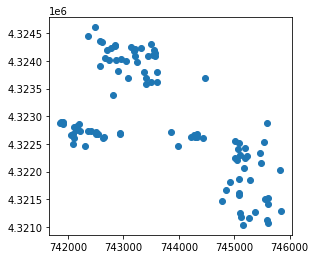

In [13]:
bsu_gpr_sample.plot()

## ASO data

### Which columns does the ImageData table have?

In [14]:
# Use the function to see what columns are available to use. 
db_columns = get_table_attributes(ImageData)

# Print out the results nicely
print("These are the available columns in the table:\n \n* {}\n".format('\n* '.join(db_columns)))

These are the available columns in the table:
 
* date
* date_accessed
* description
* doi
* instrument
* metadata
* observers
* raster
* registry
* site_name
* time_created
* time_updated
* type
* units



In [15]:
# Search through the `observers` field for ASO, new name since 2021
airborne_sensors_list = session.query(ImageData.observers).distinct().all()

print('list of airborne sensors by "observer" name: \n', airborne_sensors_list)

list of airborne sensors by "observer" name: 
 [('USGS',), ('UAVSAR team, JPL',), ('ASO Inc.',)]


In [16]:
# Query the session using .observers() to generate a list
# Locate all that are distinct
airborne_dataset_types = session.query(ImageData.type).distinct().all()

print('list of airborne sensors by "observer" name')
print(airborne_dataset_types)

list of airborne sensors by "observer" name
[('swe',), ('DEM',), ('insar amplitude',), ('insar correlation',), ('depth',), ('insar interferogram real',), ('insar interferogram imaginary',)]


In [17]:
query = session.query(ImageData.units)
query = query.filter(ImageData.observers == "ASO Inc.")
query = query.filter(ImageData.type == "depth")
query = query.distinct()
result = query.all()
print(result)

[('meters',)]


## We want to see the 'swe' and 'depth' data around some area of interest

### Get the ASO depth measurements for our chosen (large) bounding box

In [18]:
# arbitrary box we chose as a team, EPSG:26912
bbox_WSEN = 742000, 4322000, 747000, 4325000

In [19]:
bbox_area_square_meters = (bbox_WSEN[3] - bbox_WSEN[1]) * (bbox_WSEN[2] - bbox_WSEN[0])
# Divide by pixel size
bbox_area_square_meters

## WKB_element definition, in order to filter by our bbox

In [23]:
# Unrelated but keeping: how to pull out ALL point data from the database that falls within our box
x1, y1, x2, y2 = bbox_WSEN
polygon = shapely.geometry.Polygon([[x1, y1], [x1, y2], [x2, y2], [x2, y1]]) # used box() before
wkb_element = from_shape(polygon, srid=26912) # which srid is right?

query = session.query(PointData)
# We need to filter

# Filter the query by bounding box (the part that doesn't work)
query = query.filter(gfunc.ST_Within(PointData.geom, wkb_element))

result = query.count()
print(result) # How many database points fall within the bbox

4679570


## Fetch first ASO lidar depth dataset as a single raster

In [24]:
%%time
# Retrieve some of the ASO Snow Depth tiles
# https://snowexsql.readthedocs.io/en/latest/gallery/raster_union_and_more_example.html
query = session.query(func.ST_AsTiff(func.ST_Clip(func.ST_Union(ImageData.raster, type_=Raster), wkb_element)))
query = query.filter(ImageData.observers == "ASO Inc.")
query = query.filter(ImageData.type == "depth")
query = query.filter(ImageData.date == "2020-02-02")

# Filter the query by bounding box
query = query.filter(gfunc.ST_Intersects(ImageData.raster, wkb_element))

result = query.all()
print(result)
# Keep the rasterio object around because we need it later
aso_2020_02_02_rio = raster_to_rasterio(session, result)[0]
# Read the pixel values as a masked array
aso_2020_02_02_raster = aso_2020_02_02_rio.read(1, masked=True)

<timed exec>:11: SAWarning: Class ST_Union will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this object can make use of the cache key generated by the superclass.  Alternatively, this attribute may be set to False which will disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
<timed exec>:11: SAWarning: Class WKBElement will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this object can make use of the cache key generated by the superclass.  Alternatively, this attribute may be set to False which will disable this wa

[(<memory at 0x7f668b28c280>,)]
CPU times: user 53.6 ms, sys: 44.9 ms, total: 98.4 ms
Wall time: 3.63 s


In [28]:
aso_2020_02_02_raster.min() # check that nodata is marked as nan

nan

### How to write rasters to disk

Text(0.5, 1.0, 'ASO 2020-02-02 Depth')

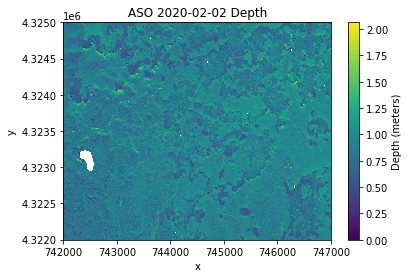

In [40]:
# Copy the profile/tiff metadata (not to be confused with the database metadata)
filename = "aso_2020_02_02_raster.tif"
with rasterio.open(filename, 'w', **aso_2020_02_02_rio.profile) as f:
    f.write(aso_2020_02_02_rio.read(1), 1)
    
# Read the raster back in so we know it worked
ASO_snow = rioxarray.open_rasterio(filename, masked=True)
ASO_snow.plot(cbar_kwargs={"label": "Depth (meters)"})
plt.title("ASO 2020-02-02 Depth")

### Check that we have the raster dimensions we expect
* Close enough, just edges of the bbox

In [53]:
bbox_area_pixels = bbox_area_square_meters / (3*3)
print(f"Expected dimensions for 3m depth product: {bbox_area_pixels:.1f}")
print(f"Actual number of pixels: {ASO_snow.shape[1]*ASO_snow.shape[2]}")

Expected dimensions for 3m depth product: 1666666.7
Actual number of pixels: 1669668


### Retrieve ASO SWE raster (smaller)

[(<memory at 0x7f6642df6f80>,)]
CPU times: user 57.6 ms, sys: 0 ns, total: 57.6 ms
Wall time: 131 ms


Text(0.5, 1.0, 'ASO 2020-02-02 SWE')

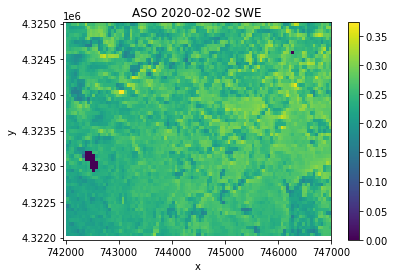

In [98]:
%%time
# Retrieve ASO SWE tiles for this date and bbox
# https://snowexsql.readthedocs.io/en/latest/gallery/raster_union_and_more_example.html
query = session.query(func.ST_AsTiff(func.ST_Clip(func.ST_Union(ImageData.raster, type_=Raster), wkb_element)))
query = query.filter(ImageData.observers == "ASO Inc.")
query = query.filter(ImageData.type == "swe")
query = query.filter(ImageData.date == "2020-02-02")

# Filter the query by bounding box
query = query.filter(gfunc.ST_Intersects(ImageData.raster, wkb_element))

result = query.all()
print(result)
aso_2020_02_02_swe_rio = raster_to_rasterio(session, result)[0]
aso_2020_02_02_swe_raster = aso_2020_02_02_swe_rio.read(1, masked=True)


filename = "aso_2020_02_02_swe_raster.tif"
with rasterio.open(filename, 'w', **aso_2020_02_02_swe_rio.profile) as f:
    f.write(aso_2020_02_02_swe_rio.read(1), 1)
ASO_2020_02_02_swe = rioxarray.open_rasterio(filename, masked=True)
ASO_2020_02_02_swe.plot()
plt.title("ASO 2020-02-02 SWE")

In [56]:
swe_bbox_area_pixels = bbox_area_square_meters / (50*50)
print(f"Expected dimensions for 50m SWE product: {swe_bbox_area_pixels:.1f}")
print(f"Actual number of SWE pixels: {aso_2020_02_02_swe_raster.shape[0]*aso_2020_02_02_swe_raster.shape[1]}") # compare to SWE dimensions for same bbox

Expected dimensions for 50m SWE product: 6000.0
Actual number of SWE pixels: 6161


## second dataset lidar depth


In [57]:
%%time
# Retrieve some of the ASO Snow Depth tiles
# https://snowexsql.readthedocs.io/en/latest/gallery/raster_union_and_more_example.html
query = session.query(func.ST_AsTiff(func.ST_Clip(func.ST_Union(ImageData.raster, type_=Raster), wkb_element)))
query = query.filter(ImageData.observers == "ASO Inc.")
query = query.filter(ImageData.type == "depth")
query = query.filter(ImageData.date == "2020-02-13")

# Filter the query by bounding box
query = query.filter(gfunc.ST_Intersects(ImageData.raster, wkb_element))

result = query.all()
print(result)

aso_2020_02_13_rio = raster_to_rasterio(session, result)[0]
aso_2020_02_13_raster = aso_2020_02_13_rio.read(1, masked=True)

[(<memory at 0x7f666dcd8400>,)]
CPU times: user 42.1 ms, sys: 28.2 ms, total: 70.3 ms
Wall time: 2.08 s


[(<memory at 0x7f6642df6bc0>,)]
CPU times: user 48.8 ms, sys: 4.1 ms, total: 52.9 ms
Wall time: 121 ms


Text(0.5, 1.0, 'ASO 2020-02-13 SWE')

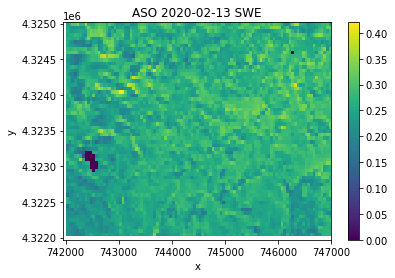

In [99]:
%%time
# Retrieve ASO SWE tiles for this date and bbox
# https://snowexsql.readthedocs.io/en/latest/gallery/raster_union_and_more_example.html
query = session.query(func.ST_AsTiff(func.ST_Clip(func.ST_Union(ImageData.raster, type_=Raster), wkb_element)))
query = query.filter(ImageData.observers == "ASO Inc.")
query = query.filter(ImageData.type == "swe")
query = query.filter(ImageData.date == "2020-02-13")

# Filter the query by bounding box
query = query.filter(gfunc.ST_Intersects(ImageData.raster, wkb_element))

result = query.all()
print(result)
aso_2020_02_13_swe_rio = raster_to_rasterio(session, result)[0]
aso_2020_02_13_swe_raster = aso_2020_02_13_swe_rio.read(1, masked=True)

filename = "aso_2020_02_13_swe_raster.tif"
with rasterio.open(filename, 'w', **aso_2020_02_13_swe_rio.profile) as f:
    f.write(aso_2020_02_13_swe_rio.read(1), 1)
ASO_2020_02_13_swe = rioxarray.open_rasterio(filename, masked=True)
ASO_2020_02_13_swe.plot()
plt.title("ASO 2020-02-13 SWE")

## Create a difference map ASO depth 2 - ASO depth 1

Range of changes in the (meters) -1.296957 1.1872813


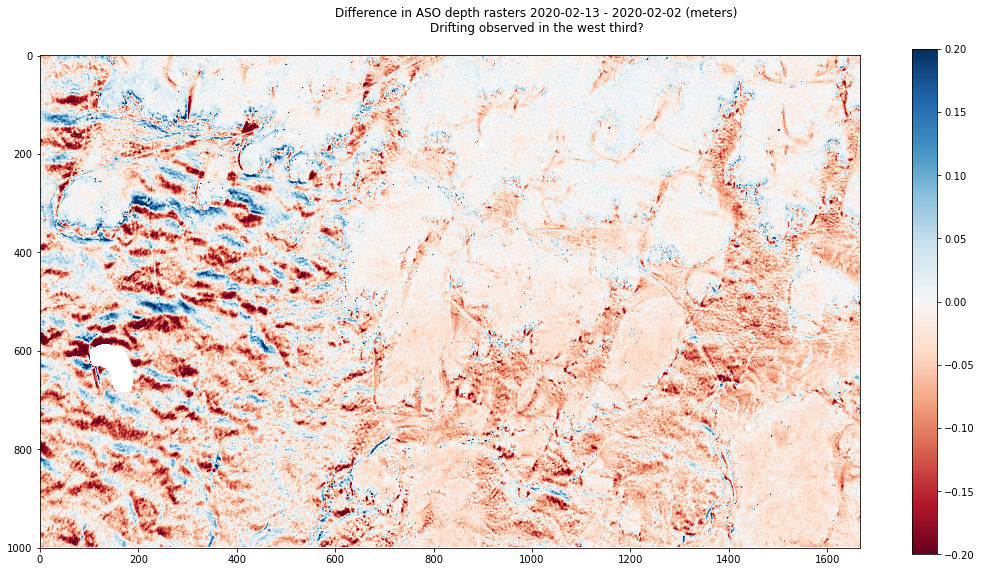

In [63]:
# Redo with rioxarray so we don't lose the coordinate information
fig, ax = plt.subplots(figsize=(15,8))
diff = aso_2020_02_13_raster - aso_2020_02_02_raster

print("Range of changes in the (meters)", np.nanmin(diff), np.nanmax(diff))
# show(diff, ax=ax, cmap="RdBu")
data = ax.imshow(diff, cmap="RdBu", vmin=-0.2, vmax=0.2)
fig.suptitle("Difference in ASO depth rasters 2020-02-13 - 2020-02-02 (meters)\nDrifting observed in the west third?")

fig.colorbar(data, ax=ax)
plt.tight_layout()
# Got a lot of GPR data where the drifting happened

Text(0, 0.5, 'Number of pixels in bin')

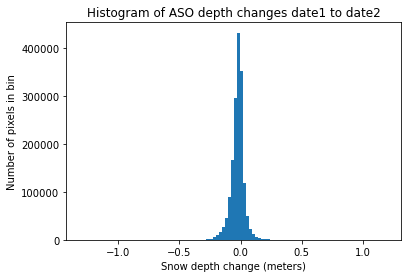

In [75]:
plt.hist(diff.reshape(-1), bins=100)
plt.title("Histogram of ASO depth changes date1 to date2")
plt.xlabel("Snow depth change (meters)")
plt.ylabel("Number of pixels in bin")
# Can change the axis limits to ignore outliers and see the distribution better

Range of changes in the (meters) -1.296957 1.1872813


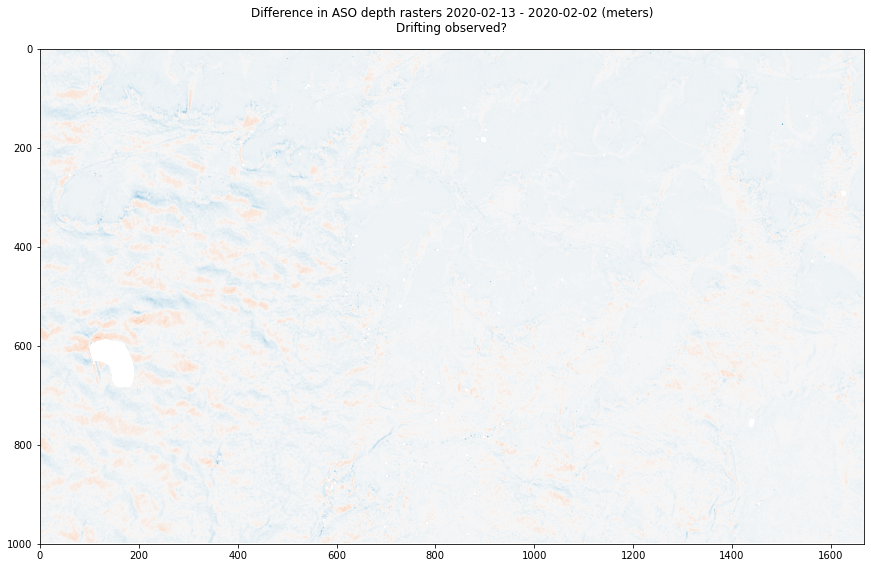

In [66]:
# Redo with rioxarray so we don't lose the coordinate information
fig, ax = plt.subplots(figsize=(15,8))
diff = aso_2020_02_13_raster - aso_2020_02_02_raster
# diff_filt = np.where(diff, diff < 0)
# diff_filt = diff_filt.where(diff_filt, diff_filt > -0.5)
# print(diff_filt.shape)
# diff_filt.reshape(diff.shape)

print("Range of changes in the (meters)", np.nanmin(diff), np.nanmax(diff))
show(diff, ax=ax, cmap="RdBu")
fig.suptitle("Difference in ASO depth rasters 2020-02-13 - 2020-02-02 (meters)\nDrifting observed?")

# plt.colorbar()
plt.tight_layout()
# Got a lot of GPR data where the drifting happened

### Also plot SWE difference map for completeness

Text(0.5, 1.0, 'ASO SWE difference map')

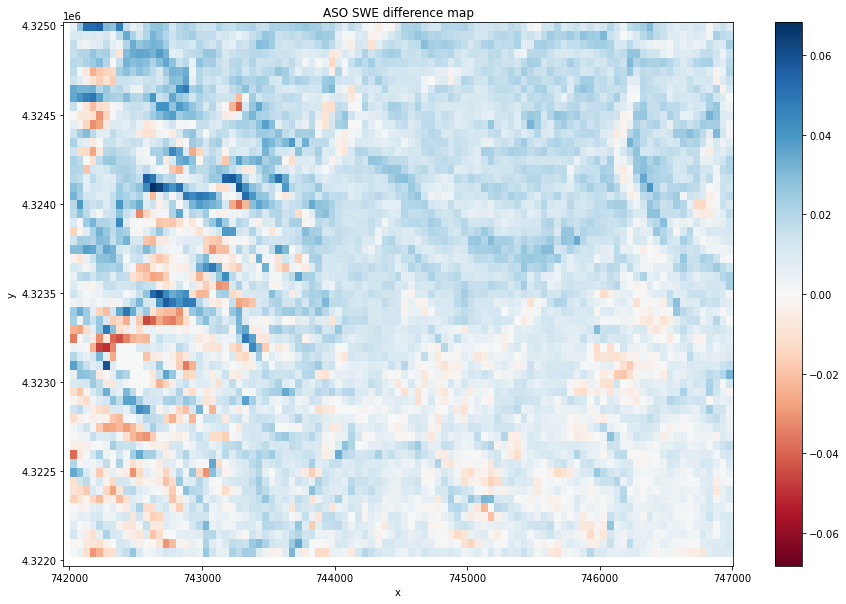

In [101]:
(ASO_2020_02_13_swe - ASO_2020_02_02_swe).plot(cmap="RdBu",figsize=(15,10))
plt.title("ASO SWE difference map")

## First try: get the raster value at given points (GPR point)
* Did not use this way

In [76]:
# 
x,y = 742000, 4322000#, 747000, 4325000
point = func.ST_SetSRID(func.ST_MakePoint(x,y), 26912)
query = session.query(func.ST_Value(ImageData.raster, point), ImageData.date, ImageData.id, ImageData.type)
query = query.filter(ImageData.observers == "ASO Inc.")
query = query.filter(gfunc.ST_Intersects(ImageData.raster, point))
query = query.filter(ImageData.type.in_(["depth", "swe"]))# == "depth")

result = query.all()
print(result)

[(0.5974472761154175, datetime.date(2020, 2, 13), 155410, 'depth'), (0.7268164157867432, datetime.date(2020, 2, 2), 154990, 'depth'), (0.2043323665857315, datetime.date(2020, 2, 2), 154681, 'swe'), (0.1875717043876648, datetime.date(2020, 2, 13), 154683, 'swe')]


/tmp/ipykernel_356/3573071087.py:9: SAWarning: Class ST_Value will not make use of SQL compilation caching as it does not set the 'inherit_cache' attribute to ``True``.  This can have significant performance implications including some performance degradations in comparison to prior SQLAlchemy versions.  Set this attribute to True if this object can make use of the cache key generated by the superclass.  Alternatively, this attribute may be set to False which will disable this warning. (Background on this error at: https://sqlalche.me/e/14/cprf)
  result = query.all()


In [83]:
%%time
# Retrieve depth & SWE from database at each (x,y) coordinate
raster_values_at_points = []
for x in range(742000, 747000, 1000):
    for y in range(4322000, 4325000, 1000):
        point = func.ST_SetSRID(func.ST_MakePoint(x,y), 26912)
        query = session.query(func.ST_Value(ImageData.raster, point), ImageData.date, ImageData.id, ImageData.type)
        query = query.filter(ImageData.observers == "ASO Inc.")
        query = query.filter(gfunc.ST_Intersects(ImageData.raster, point))
        query = query.filter(ImageData.type.in_(["depth", "swe"]))# == "depth")
        
        result = query.all()
        raster_values_at_points.append(result)
        print(f"{x} {y} = {result}\n")
        

742000 4322000 = [(0.5974472761154175, datetime.date(2020, 2, 13), 155410, 'depth'), (0.7268164157867432, datetime.date(2020, 2, 2), 154990, 'depth'), (0.2043323665857315, datetime.date(2020, 2, 2), 154681, 'swe'), (0.1875717043876648, datetime.date(2020, 2, 13), 154683, 'swe')]

742000 4323000 = [(0.6938828229904175, datetime.date(2020, 2, 13), 155380, 'depth'), (0.7949316501617432, datetime.date(2020, 2, 2), 154960, 'depth'), (0.22102302312850952, datetime.date(2020, 2, 2), 154681, 'swe'), (0.20775052905082703, datetime.date(2020, 2, 13), 154683, 'swe')]

742000 4324000 = [(0.6731054782867432, datetime.date(2020, 2, 2), 154930, 'depth'), (0.6413925886154175, datetime.date(2020, 2, 13), 155350, 'depth'), (0.22901344299316406, datetime.date(2020, 2, 2), 154681, 'swe'), (0.2450789511203766, datetime.date(2020, 2, 13), 154683, 'swe')]

743000 4322000 = [(0.22442303597927094, datetime.date(2020, 2, 2), 154681, 'swe'), (0.2244858741760254, datetime.date(2020, 2, 13), 154683, 'swe'), (0.721

In [86]:
len(raster_values_at_points) # 3x5 km so 15 points 1000m spacing

15

# Data fusion

## "The stuff from post it notes about getting the data" aka how we did the data fusion step!

### Add ASO depth/swe/pixel coordinate information to the GPR dataframe
* **For each dataframe row, extract the right SWE + depth values to add as new columns**

In [88]:
gdf = gpd.read_file("GPR_ALL.csv")

In [87]:
new_columns = [
    "ASO_IDX",
    "ASO_X",
    "ASO_Y",
    "ASO_2020_02_02_SD",
    "ASO_2020_02_13_SD",
    "ASO_2020_02_02_SWE",
    "ASO_2020_02_13_SWE",
    "ASO_SWE_IDX",
    "ASO_SWE_X",
    "ASO_SWE_Y"
]

def f(row):
    """Impelmentation of the fusion step as described on post-it in Google Doc"""
    x,y = float(row["easting"]), float(row["northing"])
    pixel_idx_x, pixel_idx_y = aso_2020_02_13_rio.index(x, y) # origin is top left or bottom left?
    pixel_center_x, pixel_center_y = aso_2020_02_13_rio.xy(pixel_idx_x, pixel_idx_y)
    value = aso_2020_02_13_raster[pixel_idx_x, pixel_idx_y]
    
    # Double check that the two ASO rasters are exactly the same
    pixel1_idx_x, pixel1_idx_y = aso_2020_02_02_rio.index(x, y)
    assert pixel_idx_x == pixel1_idx_x, f"{pixel_idx_x} != {pixel1_idx_x}"
    assert pixel_idx_y == pixel1_idx_y, f"{pixel_idx_y} != {pixel1_idx_y}"    
    
    # SWE both grids should have same index
    swe1_idx_x, swe1_idx_y = aso_2020_02_02_swe_rio.index(x, y)
    swe2_idx_x, swe2_idx_y = aso_2020_02_13_swe_rio.index(x, y)
    assert swe1_idx_x == swe2_idx_x, f"{swe1_idx_x} != {swe2_idx_x}"
    assert swe1_idx_y == swe2_idx_y, f"{swe1_idx_y} != {swe2_idx_y}"
    swe_idx_x = swe1_idx_x
    swe_idx_y = swe1_idx_y
    
    swe_pixel_center_x, swe_pixel_center_y = aso_2020_02_02_swe_rio.xy(swe_idx_x, swe_idx_y)
    
    # All of our new columns for the Dataframe
    aso_idx = f"x_idx={pixel_idx_x},y_idx={pixel_idx_y}" # how we will group
    aso_x = pixel_center_x
    aso_y = pixel_center_y
    aso_2020_02_02_sd = aso_2020_02_02_raster[pixel_idx_x, pixel_idx_y]
    aso_2020_02_13_sd = aso_2020_02_13_raster[pixel_idx_x, pixel_idx_y]
    aso_2020_02_02_swe = aso_2020_02_02_swe_raster[swe_idx_x, swe_idx_y]
    aso_2020_02_13_swe = aso_2020_02_13_swe_raster[swe_idx_x, swe_idx_y]

    return [
        aso_idx,
        aso_x,
        aso_y,
        aso_2020_02_02_sd,
        aso_2020_02_13_sd,
        aso_2020_02_02_swe,
        aso_2020_02_13_swe,
        # Also save the info about which ASO SWE pixel we found
        f"x_idx={swe_pixel_center_x},y_idx={swe_pixel_center_y}", # how we can group
        swe_idx_x,
        swe_idx_y
    ]
    
    # print(value)
    return value

In [89]:
%%time
## This is very slow (minutes?) - we could try using the database, query is roughly:
## select GPR_xy, GPR_columns, value_of_rasters_near_GPR_xy
## from some sort of join of the GPR + Image tables
## where the xy is inside our BBOX
## 100000 rows takes 30? seconds on medium instance
## 1.5 million rows took 10 minutes
df_of_new_columns = gdf.head(100).apply(lambda row: pd.Series(f(row), index=new_columns), axis=1)
# gdf["aso_snow_depth_2020_02_13"] = gdf.apply(f, axis=1)
df_of_new_columns

CPU times: user 202 ms, sys: 15.8 ms, total: 218 ms
Wall time: 217 ms


,ASO_IDX,ASO_X,ASO_Y,ASO_2020_02_02_SD,ASO_2020_02_13_SD,ASO_2020_02_02_SWE,ASO_2020_02_13_SWE,ASO_SWE_IDX,ASO_SWE_X,ASO_SWE_Y
0,"x_idx=218,y_idx=383",743149.500002,4.324345e+06,0.948984,0.945836,0.269165,0.29294,"x_idx=743129.0114751605,y_idx=4324342.9880095",13,23
1,"x_idx=218,y_idx=383",743149.500002,4.324345e+06,0.948984,0.945836,0.269165,0.29294,"x_idx=743129.0114751605,y_idx=4324342.9880095",13,23
2,"x_idx=218,y_idx=383",743149.500002,4.324345e+06,0.948984,0.945836,0.269165,0.29294,"x_idx=743129.0114751605,y_idx=4324342.9880095",13,23
3,"x_idx=218,y_idx=383",743149.500002,4.324345e+06,0.948984,0.945836,0.269165,0.29294,"x_idx=743129.0114751605,y_idx=4324342.9880095",13,23
4,"x_idx=218,y_idx=383",743149.500002,4.324345e+06,0.948984,0.945836,0.269165,0.29294,"x_idx=743129.0114751605,y_idx=4324342.9880095",13,23
...,...,...,...,...,...,...,...,...,...,...
95,"x_idx=219,y_idx=382",743146.500002,4.324342e+06,0.939219,0.992711,0.269165,0.29294,"x_idx=743129.0114751605,y_idx=4324342.9880095",13,23
96,"x_idx=219,y_idx=382",743146.500002,4.324342e+06,0.939219,0.992711,0.269165,0.29294,"x_idx=743129.0114751605,y_idx=4324342.9880095",13,23
97,"x_idx=219,y_idx=382",743146.500002,4.324342e+06,0.939219,0.992711,0.269165,0.29294,"x_idx=743129.0114751605,y_idx=4324342.9880095",13,23
98,"x_idx=219,y_idx=382",743146.500002,4.324342e+06,0.939219,0.992711,0.269165,0.29294,"x_idx=743129.0114751605,y_idx=4324342.9880095",13,23


In [91]:
df_of_new_columns.to_csv("df_of_aso_columns.csv")

In [92]:
gdf_combined = pd.concat([gdf,df_of_new_columns], axis=1)
gdf_combined.geometry = gpd.points_from_xy(gdf_combined["easting"], gdf_combined["northing"])
gdf_combined.head()

,field_1,geom,easting,northing,twt,date,geometry,ASO_IDX,ASO_X,ASO_Y,ASO_2020_02_02_SD,ASO_2020_02_13_SD,ASO_2020_02_02_SWE,ASO_2020_02_13_SWE,ASO_SWE_IDX,ASO_SWE_X,ASO_SWE_Y
0,0,POINT (743148.4280291862 4324346.7150880415),743148.4280291862,4324346.7150880415,8.3,2020-01-28,POINT (743148.428 4324346.715),"x_idx=218,y_idx=383",743149.500002,4.324345e+06,0.948984,0.945836,0.269165,0.29294,"x_idx=743129.0114751605,y_idx=4324342.9880095",13.0,23.0
1,1,POINT (743148.4040291404 4324346.714088032),743148.4040291404,4324346.714088032,8.3,2020-01-28,POINT (743148.404 4324346.714),"x_idx=218,y_idx=383",743149.500002,4.324345e+06,0.948984,0.945836,0.269165,0.29294,"x_idx=743129.0114751605,y_idx=4324342.9880095",13.0,23.0
2,2,POINT (743148.2910291193 4324346.702088035),743148.2910291193,4324346.702088035,8.3,2020-01-28,POINT (743148.291 4324346.702),"x_idx=218,y_idx=383",743149.500002,4.324345e+06,0.948984,0.945836,0.269165,0.29294,"x_idx=743129.0114751605,y_idx=4324342.9880095",13.0,23.0
3,3,POINT (743148.3820291588 4324346.713088031),743148.3820291588,4324346.713088031,8.3,2020-01-28,POINT (743148.382 4324346.713),"x_idx=218,y_idx=383",743149.500002,4.324345e+06,0.948984,0.945836,0.269165,0.29294,"x_idx=743129.0114751605,y_idx=4324342.9880095",13.0,23.0
4,4,POINT (743148.3610291365 4324346.711088029),743148.3610291365,4324346.711088029,8.3,2020-01-28,POINT (743148.361 4324346.711),"x_idx=218,y_idx=383",743149.500002,4.324345e+06,0.948984,0.945836,0.269165,0.29294,"x_idx=743129.0114751605,y_idx=4324342.9880095",13.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549191,1549191,POINT (746608.7858845077 4324145.780659125),746608.7858845077,4324145.780659125,4.83,2020-02-04,POINT (746608.786 4324145.781),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1549192,1549192,POINT (746608.7858845077 4324145.780659125),746608.7858845077,4324145.780659125,4.83,2020-02-04,POINT (746608.786 4324145.781),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1549193,1549193,POINT (746608.7858845077 4324145.780659125),746608.7858845077,4324145.780659125,4.83,2020-02-04,POINT (746608.786 4324145.781),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1549194,1549194,POINT (746608.7858845077 4324145.780659125),746608.7858845077,4324145.780659125,4.78,2020-02-04,POINT (746608.786 4324145.781),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
gdf_combined.to_csv("GPR_AND_ASO_ALL.CSV")

In [105]:
gdf_combined.dtypes

field_1                 object
geom                    object
easting                 object
northing                object
twt                     object
date                    object
geometry              geometry
ASO_IDX                 object
ASO_X                  float64
ASO_Y                  float64
ASO_2020_02_02_SD       object
ASO_2020_02_13_SD       object
ASO_2020_02_02_SWE      object
ASO_2020_02_13_SWE      object
dtype: object

In [109]:
new_columns[3:]

['ASO_2020_02_02_SD',
 'ASO_2020_02_13_SD',
 'ASO_2020_02_02_SWE',
 'ASO_2020_02_13_SWE']

In [122]:
# Convert all the dataframe columns to the right types
columns_to_convert = [
    'twt',
    'ASO_2020_02_02_SD',
    'ASO_2020_02_13_SD',
    'ASO_2020_02_02_SWE',
    'ASO_2020_02_13_SWE'
]
for column in columns_to_convert:
    gdf_combined[column] = gdf_combined[column].astype(float)
    
gdf_combined["date"] = pd.to_datetime(gdf_combined["date"])

In [123]:
gdf_combined.dtypes

field_1                       object
geom                          object
easting                       object
northing                      object
twt                          float64
date                  datetime64[ns]
geometry                    geometry
ASO_IDX                       object
ASO_X                        float64
ASO_Y                        float64
ASO_2020_02_02_SD            float64
ASO_2020_02_13_SD            float64
ASO_2020_02_02_SWE           float64
ASO_2020_02_13_SWE           float64
dtype: object

In [124]:
gdf_combined

,field_1,geom,easting,northing,twt,date,geometry,ASO_IDX,ASO_X,ASO_Y,ASO_2020_02_02_SD,ASO_2020_02_13_SD,ASO_2020_02_02_SWE,ASO_2020_02_13_SWE
0,0,POINT (743148.4280291862 4324346.7150880415),743148.4280291862,4324346.7150880415,8.30,2020-01-28,POINT (743148.428 4324346.715),"x_idx=218,y_idx=383",743149.500002,4.324345e+06,0.948984,0.945836,0.269165,0.292940
1,1,POINT (743148.4040291404 4324346.714088032),743148.4040291404,4324346.714088032,8.30,2020-01-28,POINT (743148.404 4324346.714),"x_idx=218,y_idx=383",743149.500002,4.324345e+06,0.948984,0.945836,0.269165,0.292940
2,2,POINT (743148.2910291193 4324346.702088035),743148.2910291193,4324346.702088035,8.30,2020-01-28,POINT (743148.291 4324346.702),"x_idx=218,y_idx=383",743149.500002,4.324345e+06,0.948984,0.945836,0.269165,0.292940
3,3,POINT (743148.3820291588 4324346.713088031),743148.3820291588,4324346.713088031,8.30,2020-01-28,POINT (743148.382 4324346.713),"x_idx=218,y_idx=383",743149.500002,4.324345e+06,0.948984,0.945836,0.269165,0.292940
4,4,POINT (743148.3610291365 4324346.711088029),743148.3610291365,4324346.711088029,8.30,2020-01-28,POINT (743148.361 4324346.711),"x_idx=218,y_idx=383",743149.500002,4.324345e+06,0.948984,0.945836,0.269165,0.292940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1549191,1549191,POINT (746608.7858845077 4324145.780659125),746608.7858845077,4324145.780659125,4.83,2020-02-04,POINT (746608.786 4324145.781),"x_idx=285,y_idx=1536",746608.500002,4.324144e+06,0.691660,0.660191,0.251874,0.262587
1549192,1549192,POINT (746608.7858845077 4324145.780659125),746608.7858845077,4324145.780659125,4.83,2020-02-04,POINT (746608.786 4324145.781),"x_idx=285,y_idx=1536",746608.500002,4.324144e+06,0.691660,0.660191,0.251874,0.262587
1549193,1549193,POINT (746608.7858845077 4324145.780659125),746608.7858845077,4324145.780659125,4.83,2020-02-04,POINT (746608.786 4324145.781),"x_idx=285,y_idx=1536",746608.500002,4.324144e+06,0.691660,0.660191,0.251874,0.262587
1549194,1549194,POINT (746608.7858845077 4324145.780659125),746608.7858845077,4324145.780659125,4.78,2020-02-04,POINT (746608.786 4324145.781),"x_idx=285,y_idx=1536",746608.500002,4.324144e+06,0.691660,0.660191,0.251874,0.262587


In [126]:
gdf_combined.isna().sum()

field_1                  0
geom                     0
easting                  0
northing                 0
twt                      0
date                     0
geometry                 0
ASO_IDX                  0
ASO_X                    0
ASO_Y                    0
ASO_2020_02_02_SD      202
ASO_2020_02_13_SD      200
ASO_2020_02_02_SWE    4434
ASO_2020_02_13_SWE    4434
dtype: int64

In [125]:
gdf_combined.groupby("ASO_IDX").median()

,twt,ASO_X,ASO_Y,ASO_2020_02_02_SD,ASO_2020_02_13_SD,ASO_2020_02_02_SWE,ASO_2020_02_13_SWE
ASO_IDX,,,,,,,
"x_idx=0,y_idx=335",8.27,743005.500002,4.324999e+06,1.026133,1.026891,0.220410,0.234011
"x_idx=0,y_idx=336",8.27,743008.500002,4.324999e+06,0.989512,0.988316,0.220410,0.234011
"x_idx=0,y_idx=338",5.59,743014.500002,4.324999e+06,0.772227,0.775670,0.220410,0.234011
"x_idx=0,y_idx=339",6.41,743017.500002,4.324999e+06,0.846201,0.861852,0.220410,0.234011
"x_idx=0,y_idx=351",5.00,743053.500002,4.324999e+06,0.635752,0.646275,0.210185,0.224772
...,...,...,...,...,...,...,...
"x_idx=999,y_idx=1247",9.60,745741.500002,4.322002e+06,1.026865,1.054479,NaN,NaN
"x_idx=999,y_idx=1262",7.80,745786.500002,4.322002e+06,0.934092,0.881139,NaN,NaN
"x_idx=999,y_idx=1263",7.80,745789.500002,4.322002e+06,0.904551,0.856480,NaN,NaN


In [137]:
gdf.head()

,field_1,geom,easting,northing,twt,date,geometry
0,0,POINT (743148.4280291862 4324346.7150880415),743148.4280291862,4324346.7150880415,8.3,2020-01-28,None
1,1,POINT (743148.4040291404 4324346.714088032),743148.4040291404,4324346.714088032,8.3,2020-01-28,None
2,2,POINT (743148.2910291193 4324346.702088035),743148.2910291193,4324346.702088035,8.3,2020-01-28,None
3,3,POINT (743148.3820291588 4324346.713088031),743148.3820291588,4324346.713088031,8.3,2020-01-28,None
4,4,POINT (743148.3610291365 4324346.711088029),743148.3610291365,4324346.711088029,8.3,2020-01-28,None


### Sanity check: only should have a small number of GPR points where there is no SWE/depth value

In [90]:
gdf_without_masked = gdf[(gdf["aso_snow_depth_2020_02_13"] > 0) | (gdf["aso_snow_depth_2020_02_13"] <= 0)]
len(gdf_without_masked)

KeyError: 'aso_snow_depth_2020_02_13'

In [196]:
gdf_without_masked.geometry = gpd.points_from_xy(gdf_without_masked["easting"], gdf_without_masked["northing"])

/srv/conda/envs/notebook/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [197]:
gdf_without_masked

,field_1,geom,easting,northing,twt,date,geometry,aso_snow_depth_2020_02_13
0,0,POINT (743148.4280291862 4324346.7150880415),743148.4280291862,4324346.7150880415,8.3,2020-01-28,POINT (743148.428 4324346.715),0.945836
1,1,POINT (743148.4040291404 4324346.714088032),743148.4040291404,4324346.714088032,8.3,2020-01-28,POINT (743148.404 4324346.714),0.945836
2,2,POINT (743148.2910291193 4324346.702088035),743148.2910291193,4324346.702088035,8.3,2020-01-28,POINT (743148.291 4324346.702),0.945836
3,3,POINT (743148.3820291588 4324346.713088031),743148.3820291588,4324346.713088031,8.3,2020-01-28,POINT (743148.382 4324346.713),0.945836
4,4,POINT (743148.3610291365 4324346.711088029),743148.3610291365,4324346.711088029,8.3,2020-01-28,POINT (743148.361 4324346.711),0.945836
...,...,...,...,...,...,...,...,...
1549191,1549191,POINT (746608.7858845077 4324145.780659125),746608.7858845077,4324145.780659125,4.83,2020-02-04,POINT (746608.786 4324145.781),0.660191
1549192,1549192,POINT (746608.7858845077 4324145.780659125),746608.7858845077,4324145.780659125,4.83,2020-02-04,POINT (746608.786 4324145.781),0.660191
1549193,1549193,POINT (746608.7858845077 4324145.780659125),746608.7858845077,4324145.780659125,4.83,2020-02-04,POINT (746608.786 4324145.781),0.660191
1549194,1549194,POINT (746608.7858845077 4324145.780659125),746608.7858845077,4324145.780659125,4.78,2020-02-04,POINT (746608.786 4324145.781),0.660191


In [246]:
# box is majority of the gpr data
# first 10000 points is Tate's first spiral
# 20-190cm sounds about right for snow depth
# Two-way travel time + snow pit density nearby is another fusion step
# Then we can do the
# between 1-93 in the first 10000
# keep the ones on skis together with those with the snowmobile
# Investigate the ones where there are way more in 1 pixel than I am expecting

<AxesSubplot:>

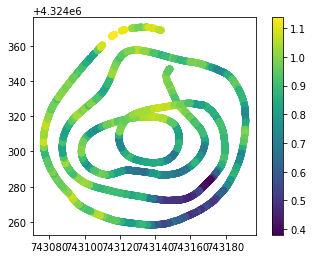

In [214]:
gdf_without_masked.head(10000).plot(column="aso_snow_depth_2020_02_13", legend=True)

In [235]:
counts = grouped.count()


In [249]:
counts.max()

field_1     1947
geom        1947
easting     1947
northing    1947
twt         1947
date        1947
geometry    1947
dtype: int64

In [247]:
counts.idxmax()

field_1     0.983189
geom        0.983189
easting     0.983189
northing    0.983189
twt         0.983189
date        0.983189
geometry    0.983189
dtype: float64

In [234]:
grouped = gdf_without_masked.groupby("aso_snow_depth_2020_02_13")

<AxesSubplot:>

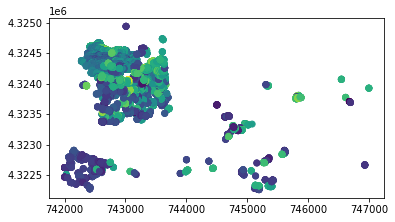

In [245]:
grouped.head().plot(column="aso_snow_depth_2020_02_13")

<AxesSubplot:>

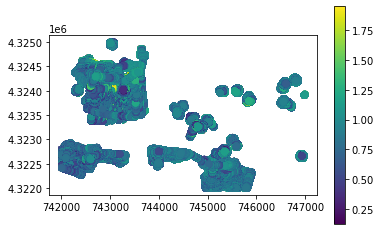

In [212]:
gdf_without_masked.plot(column="aso_snow_depth_2020_02_13", legend=True)

In [207]:
gdf_without_masked["aso_snow_depth_2020_02_13"] = gdf_without_masked["aso_snow_depth_2020_02_13"].astype(float)

/srv/conda/envs/notebook/lib/python3.10/site-packages/geopandas/geodataframe.py:1456: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [180]:
len(gdf[gdf["aso_snow_depth_2020_02_13"].notna()])

1549196

In [167]:
gdf.groupby("date").count()

,field_1,geom,easting,northing,twt,geometry,aso_snow_depth_2020_02_13
date,,,,,,,
2020-01-28,531650,531650,531650,531650,531650,0,531650
2020-01-29,264401,264401,264401,264401,264401,0,264401
2020-01-30,57964,57964,57964,57964,57964,0,57964
2020-01-31,165227,165227,165227,165227,165227,0,165227
2020-02-01,134370,134370,134370,134370,134370,0,134370
2020-02-04,171478,171478,171478,171478,171478,0,171478
2020-02-05,68710,68710,68710,68710,68710,0,68710
2020-02-06,19763,19763,19763,19763,19763,0,19763
2020-02-07,38305,38305,38305,38305,38305,0,38305


In [158]:
gdf_combined = gdf_combined.drop("geom", axis=1)
gdf_combined = gdf_combined.drop("field_1", axis=1)

In [159]:

gdf_combined["easting"] = gdf_combined["easting"].astype(float)
gdf_combined["northing"] = gdf_combined["northing"].astype(float)

gdf_combined.dtypes

easting                      float64
northing                     float64
twt                          float64
date                  datetime64[ns]
geometry                    geometry
ASO_IDX                       object
ASO_X                        float64
ASO_Y                        float64
ASO_2020_02_02_SD            float64
ASO_2020_02_13_SD            float64
ASO_2020_02_02_SWE           float64
ASO_2020_02_13_SWE           float64
dtype: object

In [160]:
gdf_combined.isna().sum()

easting                  0
northing                 0
twt                      0
date                     0
geometry                 0
ASO_IDX                  0
ASO_X                    0
ASO_Y                    0
ASO_2020_02_02_SD      202
ASO_2020_02_13_SD      200
ASO_2020_02_02_SWE    4434
ASO_2020_02_13_SWE    4434
dtype: int64

<AxesSubplot:>

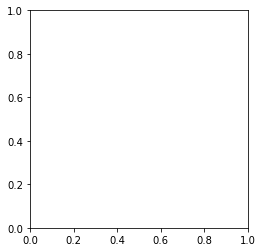

In [162]:
gdf_combined[gdf_combined.isna()].plot("ASO_2020_02_02_SD")

In [1]:
gdf_combined.tail(1000).plot("ASO_2020_02_02_SWE")

NameError: name 'gdf_combined' is not defined

In [ ]:
gdf_combined.to_csv("GPR_AND_ASO_ALL_FIXED.csv")

In [131]:
df_in = pd.read_csv("GPR_AND_ASO_ALL.CSV")

/tmp/ipykernel_2706/3697296431.py:1: DtypeWarning: Columns (11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  df_in = pd.read_csv("GPR_AND_ASO_ALL.CSV")


In [140]:
dataFusion = pd.read_csv("GPR_AND_ASO_ALL.CSV")
columns_to_convert = [
    'twt',
    'ASO_2020_02_02_SD',
    'ASO_2020_02_13_SD',
    'ASO_2020_02_02_SWE',
    'ASO_2020_02_13_SWE'
]
for column in columns_to_convert:
    dataFusion[column] = dataFusion[column].astype(float)
    
dataFusion["date"] = pd.to_datetime(dataFusion["date"])

/tmp/ipykernel_2706/2576611606.py:1: DtypeWarning: Columns (11,12,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  dataFusion = pd.read_csv("GPR_AND_ASO_ALL.CSV")


ValueError: could not convert string to float: '--'

In [138]:
dataFusion.groupby("ASO_IDX").median()

,Unnamed: 0,field_1,easting,northing,twt,ASO_X,ASO_Y
ASO_IDX,,,,,,,
"x_idx=0,y_idx=335",1106143.5,1106143.5,743006.737020,4.324998e+06,8.27,743005.500002,4.324999e+06
"x_idx=0,y_idx=336",1106985.5,1106985.5,743007.710417,4.324999e+06,8.27,743008.500002,4.324999e+06
"x_idx=0,y_idx=338",1103707.0,1103707.0,743015.408536,4.324998e+06,5.59,743014.500002,4.324999e+06
"x_idx=0,y_idx=339",1103690.0,1103690.0,743016.299799,4.324999e+06,6.41,743017.500002,4.324999e+06
"x_idx=0,y_idx=351",1103681.0,1103681.0,743054.895246,4.325000e+06,5.00,743053.500002,4.324999e+06
...,...,...,...,...,...,...,...
"x_idx=999,y_idx=1247",849166.0,849166.0,745742.355031,4.322003e+06,9.60,745741.500002,4.322002e+06
"x_idx=999,y_idx=1262",853011.0,853011.0,745787.903031,4.322001e+06,7.80,745786.500002,4.322002e+06
"x_idx=999,y_idx=1263",853792.0,853792.0,745788.368031,4.322003e+06,7.80,745789.500002,4.322002e+06


In [134]:
dataFusion.isna().sum()

Unnamed: 0            0
field_1               0
geom                  0
easting               0
northing              0
twt                   0
date                  0
geometry              0
ASO_IDX               0
ASO_X                 0
ASO_Y                 0
ASO_2020_02_02_SD     2
ASO_2020_02_13_SD     0
ASO_2020_02_02_SWE    0
ASO_2020_02_13_SWE    0
dtype: int64

In [135]:
len(dataFusion)

1549196